In [1]:
# PROCESS THE GAIA CATALOG OF STARS with CHEMISTRY from APOGEE and GALAH:
#currently just has apogee
# 
# 
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  JUNE 2024 CREATE JUPYTER NOTEBOOK

In [14]:
import pandas as pd
import numpy as np
import sys
import os
import collections

import astropy.units as u
import astropy.coordinates
from astropy.table import Table, join, unique, vstack

from astroquery.gaia import Gaia
from astroquery.vizier import Vizier

import SciServer
from SciServer import CasJobs

sys.path.insert(0, '..')
from common import file_functions, calculations

from matplotlib import pyplot as plt, colors

In [4]:
# Define the metadata for the data set. #FIX LATER
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Gaia Catalog of Nearby Stars'

metadata['catalog'] = 'The Gaia Catalogue of Nearby Stars (Gaia Collaboration, 2021)'
metadata['catalog_author'] = 'Gaia Collaboration'
metadata['catalog_year'] = '2021'
metadata['catalog_doi'] = 'doi:10.1051/0004-6361/202039498'
metadata['catalog_bibcode'] = '2021A&A...649A...6G'

metadata['prepared_by'] = 'Brian Abbott, Zack Reeves'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Chemistry'
metadata['data_group_desc'] = 'Chemistry of stars in the Milky Way mapped by Gaia and measured by APOGEE/GALAH'
metadata['data_group_desc_long'] = 'Have you ever wondered what’s out there in space? Now, thanks to Gaia EDR3, the solar neighbourhood has been mapped with great precision out to 100 pc (326 light years)'
metadata['fileroot'] = 'chem'

file_functions.generate_license_file(metadata)
file_functions.generate_asset_file(metadata)

In [9]:
#logging into CasJobs
#to make a new account: https://apps.sciserver.org/login-portal/Account/Login
from SciServer import Authentication

# #fill in with username and password
# Authentication_loginName = ''
# Authentication_loginPassword = ''

# manualtoken = Authentication.login(Authentication_loginName, Authentication_loginPassword)
manualtoken = Authentication.login()
manualtokenvalue = Authentication.token.value

Enter SciServer user name:  ········
Enter SciServer password:  ········


In [10]:
#Querying the aspcapStar table from SDSS to get chemistry info

#we select the apogee_id (2MASS style ID) and any chemistry info we want
#we may want to thresh the quality of the chemistry data
query = 'select apogee_id as apogee_id, c_fe from dr18.aspcapStar'
apogee = Table.from_pandas(CasJobs.executeQuery(query, context='DR18', format='pandas'))
apogee

apogee_id,c_fe
str19,float64
2M00431825+6154402,-9999.0
2M00443718+4040456,0.07516199
2M01362271+5415023,0.0265215
2M01473847+6041574,-9999.0
2M03585942+5611127,0.3874499
2M04052283+4911567,0.01136851
...,...
2M12442925-6056120,0.01517273
2M12443185-6059137,-0.10975


In [11]:
#creating a new column of apogee IDS without the 2M string in front
apogee['twomass_id'] = [apogee['apogee_id'][i][2:] if apogee['apogee_id'][i][:2]=='2M' else apogee['apogee_id'][i] for i in range(len(apogee))]
apogee

apogee_id,c_fe,twomass_id
str19,float64,str18
2M00431825+6154402,-9999.0,00431825+6154402
2M00443718+4040456,0.07516199,00443718+4040456
2M01362271+5415023,0.0265215,01362271+5415023
2M01473847+6041574,-9999.0,01473847+6041574
2M03585942+5611127,0.3874499,03585942+5611127
2M04052283+4911567,0.01136851,04052283+4911567
...,...,...
2M12442925-6056120,0.01517273,12442925-6056120
2M12443185-6059137,-0.10975,12443185-6059137


In [12]:
apogee['survey'] = ['apogee']*len(apogee)

In [3]:
#retrieve the GALAH DR3 dataset from Vizier
#reading in the catalogue
catalog = Vizier(catalog='J/MNRAS/506/150/stars', columns=['**'], row_limit=-1).query_constraints()
catalog[0]

recno,_2MASS,GALAH,GaiaDR2,GaiaEDR3,Survey,Field,flagRepeat,WG4Field,WG4Pipeline,Flagsp,Teff,e_Teff,Teffirfm,E_B-V_irfm,r_E_B-V_irfm,logg,e_logg,__Fe_H_,e__Fe_H_,q__Fe_H_,__Fe_H_atmo,Vmic,Vbroad,e_Vbroad,chi2sp,__alpha_Fe_,e__alpha_Fe_,o__alpha_Fe_,f__alpha_Fe_,FluxAFe,chiAFe,__Li_Fe_,e__Li_Fe_,o__Li_Fe_,f__Li_Fe_,__C_Fe_,e__C_Fe_,o__C_Fe_,f__C_Fe_,__O_Fe_,e__O_Fe_,o__O_Fe_,f__O_Fe_,__Na_Fe_,e__Na_Fe_,o__Na_Fe_,f__Na_Fe_,__Mg_Fe_,e__Mg_Fe_,o__Mg_Fe_,f__Mg_Fe_,__Al_Fe_,e__Al_Fe_,o__Al_Fe_,f__Al_Fe_,__Si_Fe_,e__Si_Fe_,o__Si_Fe_,f__Si_Fe_,__K_Fe_,e__K_Fe_,o__K_Fe_,f__K_Fe_,__Ca_Fe_,e__Ca_Fe_,o__Ca_Fe_,f__Ca_Fe_,__Sc_Fe_,e__Sc_Fe_,o__Sc_Fe_,f__Sc_Fe_,__Sc2_Fe_,e__Sc2_Fe_,o__Sc2_Fe_,f__Sc2_Fe_,__Ti_Fe_,e__Ti_Fe_,o__Ti_Fe_,f__Ti_Fe_,__Ti2_Fe_,e__Ti2_Fe_,o__Ti2_Fe_,f__Ti2_Fe_,__V_Fe_,e__V_Fe_,o__V_Fe_,f__V_Fe_,__Cr_Fe_,e__Cr_Fe_,o__Cr_Fe_,f__Cr_Fe_,__Cr2_Fe_,e__Cr2_Fe_,o__Cr2_Fe_,f__Cr2_Fe_,__Mn_Fe_,e__Mn_Fe_,o__Mn_Fe_,f__Mn_Fe_,__Co_Fe_,e__Co_Fe_,o__Co_Fe_,f__Co_Fe_,__Ni_Fe_,e__Ni_Fe_,o__Ni_Fe_,f__Ni_Fe_,__Cu_Fe_,e__Cu_Fe_,o__Cu_Fe_,f__Cu_Fe_,__Zn_Fe_,e__Zn_Fe_,o__Zn_Fe_,f__Zn_Fe_,__Rb_Fe_,e__Rb_Fe_,o__Rb_Fe_,f__Rb_Fe_,__Sr_Fe_,e__Sr_Fe_,o__Sr_Fe_,f__Sr_Fe_,__Y_Fe_,e__Y_Fe_,o__Y_Fe_,f__Y_Fe_,__Zr_Fe_,e__Zr_Fe_,o__Zr_Fe_,f__Zr_Fe_,__Mo_Fe_,e__Mo_Fe_,o__Mo_Fe_,f__Mo_Fe_,__Ru_Fe_,e__Ru_Fe_,o__Ru_Fe_,f__Ru_Fe_,__Ba_Fe_,e__Ba_Fe_,o__Ba_Fe_,f__Ba_Fe_,__La_Fe_,e__La_Fe_,o__La_Fe_,f__La_Fe_,__Ce_Fe_,e__Ce_Fe_,o__Ce_Fe_,f__Ce_Fe_,__Nd_Fe_,e__Nd_Fe_,o__Nd_Fe_,f__Nd_Fe_,__Sm_Fe_,e__Sm_Fe_,o__Sm_Fe_,f__Sm_Fe_,__Eu_Fe_,e__Eu_Fe_,o__Eu_Fe_,f__Eu_Fe_,RA_ICRS,DE_ICRS,plx,e_plx,rest,b_rest,B_rest,rlen,RVgalah,e_RVgalah,RVGaiaDR2,e_RVGaiaDR2,redflag,E_B-V_,snrc1iraf,snrc2iraf,snrc3iraf,snrc4iraf,flagGUESS,Vmag,Jmag,e_Jmag,Hmag,e_Hmag,Ksmag,e_Ksmag,Qflg2MASS,W2mag,e_W2mag,QflgWISE,AKs,e_AKs,BCKs,RUWE,_RA.icrs,_DE.icrs
,,,,,,,,,,,K,K,K,mag,,log(cm.s**-2),log(cm.s**-2),,,,,km / s,km / s,km / s,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,mas,mas,pc,pc,pc,pc,km / s,km / s,km / s,km / s,,mag,,,,,,mag,mag,mag,mag,mag,mag,mag,,mag,mag,,mag,mag,mag,,deg,deg
int32,str16,int64,int64,int64,str11,int16,uint8,str6,str4,int16,float32,float32,int16,float64,str3,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,int16,int16,float64,float64,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float32,float32,uint8,uint8,float64,float64,int16,int16,float64,float64,int16,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,uint8,float64,float64,uint8,int16,float64,float64,int16,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,int16,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,uint8,int16,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,int16,float32,float64,float64,float64,float64,uint8,float64,float32,float32,float32,float32,float32,float32,str3,float32,float32,str4,float32,float32,float64,float64,float64,float64
1,03325271-6840304,131116000501002,4667368899326729856,4667368899326729856,galah_main,138,0,10k_2,lbol,0,4553.35,137.06,4138,0.048000,sfd,4.714953,0.201216,-0.335019,0.120219,0,-0.109347,0.948537,9.345594,2.508091,0.58739,0.351368,0.0791933,405,0,0.73447,0.80795,-0.183756,0.1285484,1,1,--,--,--,32,1.214647,0.2138376,1,1,0.145268,0.1148905,1,0,-0.088498,0.1915507,1,0,0.467331,0.1186181,1,0,--,--,1,32,0.440389,0

In [5]:
#choosing our GALAH columns
#we take the 2MASS id and any chemistry data we want
galah = catalog[0][['_2MASS', '__C_Fe_']]
galah.rename_column('_2MASS', 'twomass_id')

galah['survey'] = ['galah']*len(galah)

In [ ]:
#threshing galah data


In [15]:
data = vstack([apogee, galah])

In [18]:
#Query Gaia ESA ADQL server using apogee_ids to match to Gaia stars and obtain proper motion to calculate uvw as well as photometric data

#log in to Gaia Server - Can change to different credentials file for a different user
Gaia.login(credentials_file='../common/gaia_credentials.txt')

#grab username from file
file = open('../common/gaia_credentials.txt', 'r')
username = file.readline().strip()

# #Upload table (table name will be forced to lowercase)
# job = Gaia.upload_table(upload_resource=data[['twomass_id']], table_name="chemistry_stars", format="csv")

#Query Gaia DR3 source for parallaxes
#Potentially want Bailer Jones distances pending figuring out the parallax error issue
job = Gaia.launch_job_async("select a.twomass_id, "
                            "gaia_match.source_id, "
                            "bj.r_med_geo, bj.r_hi_geo, bj.r_lo_geo, bj.r_med_photogeo, bj.r_hi_photogeo, bj.r_lo_photogeo, "
                            "c.ra, c.dec, c.pmra, c.pmdec, c.radial_velocity, c.phot_g_mean_mag, c.bp_g, c.teff_gspphot "
                            "from user_"+username+".chemistry_stars a inner join gaiadr3.tmass_psc_xsc_best_neighbour gaia_match on a.twomass_id = gaia_match.original_ext_source_id "
                            "inner join external.gaiaedr3_distance bj on gaia_match.source_id = bj.source_id "
                            "inner join gaiadr3.gaia_source c on gaia_match.source_id = c.source_id",
                            dump_to_file=False)

#put the resulting table into a dataframe and fix the dtype of the apogee_id column
query_data = job.get_results()
query_data['twomass_id'] = query_data.Column(data=[str(query_data['twomass_id'][i]) for i in range(len(query_data))],
                                                   meta=collections.OrderedDict([('ucd', 'meta.id.tmass')]), 
                                                   description='2MASS ID')

#Deleting table and job from Gaia ESA server so we don't clog the memory
Gaia.delete_user_table('chemistry_stars')
Gaia.remove_jobs(job.jobid)

Gaia.logout()

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
INFO: Query finished. [astroquery.utils.tap.core]
Table 'chemistry_stars' deleted.
Removed jobs: '1718905275927O'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


In [19]:
#join table onto data
data = unique(join(data, query_data, keys='twomass_id', join_type='inner'), keys=['twomass_id', 'SOURCE_ID'])
data

apogee_id,c_fe,twomass_id,survey,__C_Fe_,SOURCE_ID,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,ra,dec,pmra,pmdec,radial_velocity,phot_g_mean_mag,bp_g,teff_gspphot
,,,,,,pc,pc,pc,pc,pc,pc,deg,deg,mas / yr,mas / yr,km / s,mag,mag,K
str19,float64,str18,str6,float64,int64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32
2M00000002+7417074,0.009294704,00000002+7417074,apogee,--,538028216707715712,3234.5747,3464.5564,3027.0295,3268.601,3507.7324,3115.693,0.0002052024238820092,74.28543607186924,0.048581990982767526,0.5222484917399337,-52.478863,11.698828,1.5734205,3739.0503
--,--,00000011+0522500,galah,--,2745049530295263232,149.40038,149.9331,148.93335,149.60596,150.17287,148.91833,0.0005898233877197715,5.380517264865798,22.18405851553606,-10.296050520511521,11.894795,12.95553,0.63337135,4491.7026
2M00000019-1924498,0.061738,00000019-1924498,apogee,--,2413929812587459072,2294.9001,3922.614,1648.5955,888.34845,970.81085,797.92316,0.0009695048054116059,-19.41392221986823,20.290022745668313,-10.34126036057617,16.96445,12.288161,0.22672176,--
--,--,00000023-5709445,galah,--,4922452332795612416,349.86786,352.48358,347.00424,350.31863,352.661,348.21082,0.0013749931265087923,-57.162456775555796,48.08107589962254,-26.27555941516259,-16.979082,13.600912,0.44777012,5534.2793
--,--,00000024-5742487,galah,--,4919409709243747968,644.3016,660.44946,631.9431,642.3535,652.86273,627.6807,0.0007863545834172339,-57.7136167776798,-25.856213632249286,-19.84587011280216,34.557667,13.280836,0.31631756,--
--,--,00000025-7541166,galah,--,4685221429109310080,259.58597,260.12106,258.87897,259.54593,260.17944,258.923,0.0015526068490404113,-75.68803023457961,36.991525552861845,-3.5607094414381435,22.977255,12.207837,0.37499428,5422.1064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2M23595886-2009435,-9999.0,23595886-2009435,apogee,--,2341765776376373376,680.94275,690.2706,671.04486,681.72614,692.326,674.2222,359.9952946082676,-20.16216642717209,10.243935790870314,-0.7526317006135734,-0.78612643,12.903441,0.37759304,5500.4463


In [12]:
data

twomass_id,c_fe,apogee_id,SOURCE_ID,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,ra,dec,pmra,pmdec,radial_velocity,phot_g_mean_mag,bp_g,teff_gspphot
,,,,pc,pc,pc,pc,pc,pc,deg,deg,mas / yr,mas / yr,km / s,mag,mag,K
str19,float64,str18,int64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32
2M00000002+7417074,0.009294704,00000002+7417074,538028216707715712,3234.5747,3464.5564,3027.0295,3268.601,3507.7324,3115.693,0.0002052024238820092,74.28543607186924,0.048581990982767526,0.5222484917399337,-52.478863,11.698828,1.5734205,3739.0503
2M00000019-1924498,0.061738,00000019-1924498,2413929812587459072,2294.9001,3922.614,1648.5955,888.34845,970.81085,797.92316,0.0009695048054116059,-19.41392221986823,20.290022745668313,-10.34126036057617,16.96445,12.288161,0.22672176,--
2M00000032+5737103,0.11273,00000032+5737103,422596679964513792,762.9458,767.3334,758.2913,761.33,766.5322,756.7403,0.001331957360681545,57.61950659485637,-0.41027406737342575,-3.226601467860171,-21.289434,12.220947,0.42905617,6385.489
2M00000035-7323394,-0.31207,00000035-7323394,4689447878791422208,12516.2295,17395.037,8956.699,7310.7515,11760.366,5323.142,0.001480676840787791,-73.39432281286818,0.2554080386547546,-1.2691755061727426,--,16.747824,0.6383133,4877.1636
2M00000068+5710233,-0.025731,00000068+5710233,421077597267551104,718.71344,727.03937,709.5037,715.0294,723.68005,706.5003,0.0029132576484154813,57.17307485094373,5.7917245260706105,-12.73558885217783,-13.462213,12.275905,0.5551958,--
2M00000103+1525513,0.04991698,00000103+1525513,2772097619417608704,473.27496,477.08853,469.28427,473.27005,477.71826,468.36456,0.004303599118235232,15.430910675117346,-3.242845148588203,-8.75144181996673,-14.599077,12.282099,0.29906178,6298.066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2M23595867-7339039,-0.68267,23595867-7339039,6379920759951899648,7137.5376,10031.347,5492.0244,8901.245,13811.388,7045.2617,359.99448902420573,-73.65115033981152,0.45637612140011596,-1.471292803970081,--,17.396803,0.6019535,5399.588


In [13]:
#setting dcalc based on r_med_geo (if>500pc and photogeo exists, we choose photogeo and set dcalc to 1, else geo and dcalc to 2)
data['dcalc'] = [1 if((not(np.ma.is_masked(data['r_med_photogeo'][i])))and(data['r_med_geo'][i]>500)) else 2 for i in range(len(data))]

#setting metadata for dcalc
data['dcalc'] = data.Column(data['dcalc'],
                            meta=collections.OrderedDict([('ucd', 'meta.dcalc')]),
                            description='Distance Indicator: 1 indicates a Bailer-Jones photogeometric distance; 2 indicates a Bailer-Jones geometric distance')

#Choosing distance based on dcalc
data['bj_distance'] = [data['r_med_photogeo'][i] if data['dcalc'][i]==1 else data['r_med_geo'][i] for i in range(len(data))]
data['bj_distance'].unit=u.pc

#Choosing and calculating distance error based on the distance we chose
data['e_bj_dist'] = [((data['r_hi_photogeo'][i]-data['r_lo_photogeo'][i])/2)*u.pc if((not(np.ma.is_masked(data['r_med_photogeo'][i])))and(data['r_med_geo'][i]>500)) else ((data['r_hi_geo'][i]-data['r_lo_geo'][i])/2)*u.pc for i in range(len(data))]

In [14]:
#calculating distance in light years and parsecs
calculations.get_distance(data, dist='bj_distance', use='distance')

In [16]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', radial_velocity='radial_velocity', frame='icrs')

In [17]:
#calculating absolute magnitudes
#calculate absolute V mag based on apparent magnitude and distance
data['appmag'] = data.MaskedColumn(data=data['phot_g_mean_mag'],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.mag;em.opt.G')]),
                             format='{:.6f}',
                             description='Apparent magnitude in Gaia G-band')
data['absmag'] = data.MaskedColumn(data=[data['appmag'][i]+5-5*np.log10(data['dist_pc'][i]) for i in range(len(data))],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.magAbs;em.opt.G')]),
                             format='{:.6f}',
                             description='Absolute magnitude in Gaia G-band')

/Users/zackreeves/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/zackreeves/anaconda3/lib/python3.11/site-packages/astropy/table/column.py:555: UserWarning: Warning: converting a masked element to nan.
  self_data = np.array(data, dtype=dtype, copy=copy)


In [18]:
#calculate luminosity based on absolute magnitude
data['lum'] = [10**(1.89 - 0.4*data['absmag'][i]) for i in range(len(data))]
small_luminosities = np.where((data['lum']>0.0) & (data['lum']<0.001))[0]
data['lum'][small_luminosities] = [0.001]*len(small_luminosities)

data['lum'] = data.MaskedColumn(data=data['lum'],
                             unit=u.solLum,
                             meta=collections.OrderedDict([('ucd', 'phys.luminosity')]),
                             format='{:.6f}',
                             description='Stellar Luminosity')

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 6.0000e+00,
        4.0000e+00, 5.0000e+00, 2.0000e+00, 4.0000e+00, 3.0000e+00,
        1.2000e+01, 5.0000e+00, 6.0000e+00, 8.0000e+00, 9.0000e+00,
        6.0000e+00, 4.0000e+00, 8.0000e+00, 6.00

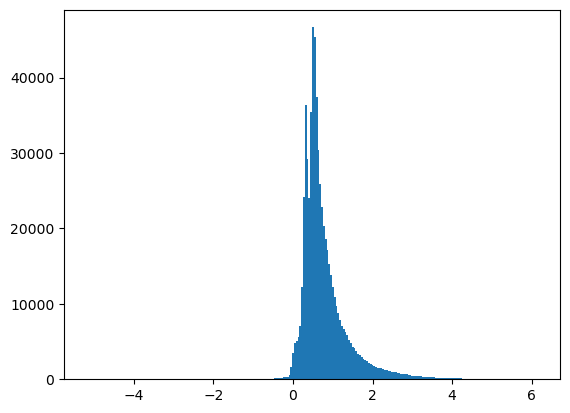

In [19]:
#setting color and visualizing
data['color'] = data.MaskedColumn(data=data['bp_g'],
                             unit=u.solLum,
                             meta=collections.OrderedDict([('ucd', 'phys.color')]),
                             format='{:.2f}',
                             description='Gaia BP-G color')
plt.hist(data['color'], bins=250)

<function matplotlib.pyplot.show(close=None, block=None)>

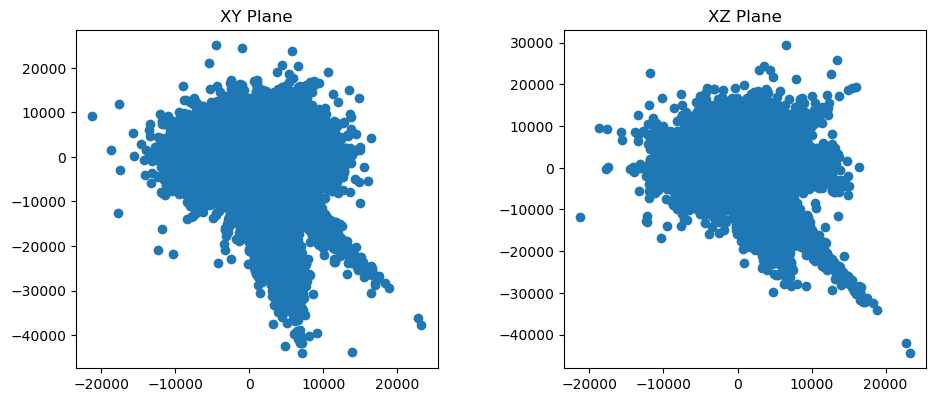

In [20]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

In [21]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['SOURCE_ID']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia DR3 Source ID')

#construct a label column
data['label'] = ['GaiaDR3_'+ str(source) for source in data['SOURCE_ID']]  #leaving for now in case we want to add other labels

In [22]:
#setting texture number column
data['texnum'] = data.Column(data=[1]*len(data), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [23]:
#Getting the column metadata
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,Position (x coordinate) in pc
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in pc
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in pc
3,color,solLum,float32,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
6,appmag,mag,float32,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
7,texnum,,int64,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float32,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int64,,,,meta.dcalc,Distance Indicator: 1 indicates a Bailer-Jones...


In [24]:
# Print the csv file using the to_csv function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(data), columns)

In [25]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [26]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))